##### Machine Learning Nanodegree
##### Capstone Project: Electric Vehicle Detection 
##### Salvador Nunez

# Setup

In [1]:
# Import libraries necessary for this project
import os.path
import time
import pickle

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image 

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# Import functions defined for this project, located in this repo in ev_capstone_lib.py
import ev_capstone_lib as ev

# Pretty display for notebooks
%matplotlib inline

In [2]:
# set visualization defaults
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 
              'weight':'bold','verticalalignment':'bottom'} 
axis_font = {'fontname':'Arial', 'size':'16','weight':'bold'}

# Data Exploration

## Import

In [3]:
ev_train_raw = pd.read_csv('source_files/EV_train.csv')
ev_train_labels_raw = pd.read_csv('source_files/EV_train_labels.csv')

## Inspect

In [4]:
print(ev_train_raw.shape)
print(ev_train_labels_raw.shape)

(1590, 2881)
(1590, 2881)


In [5]:
display(ev_train_raw.head())
display(ev_train_labels_raw.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Quantify Class Imbalance

In [6]:
# % EV Houses
ev_houses_raw = sum(ev_train_labels_raw.drop('House ID', axis=1).sum(axis=1) > 0)
print("{} houses have EVs, representing {:.0%} of all houses.".format(
    ev_houses_raw, ev_houses_raw/ev_train_labels_raw.shape[0]
))

485 houses have EVs, representing 31% of all houses.


In [7]:
# % EV Intervals Total
ev_intervals_raw = ev_train_labels_raw.drop('House ID', axis=1).values.sum()
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all houses.".format(
    ev_intervals_raw, ev_intervals_raw/(1590*2800)
))

106910 intervals have charging EVs, representing 2% of all intervals for all houses.


In [8]:
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all EV houses.".format(
    ev_intervals_raw, ev_intervals_raw/(485*2800)
))

106910 intervals have charging EVs, representing 8% of all intervals for all EV houses.


## Quantify Missing Values

In [9]:
print(ev_train_raw.isnull().values.any())  # Null values in training dataset?
print(ev_train_labels_raw.isnull().values.any())  #Null values in training labels?

True
False


In [10]:
# Count Nulls
ev_train_raw.isnull().sum().sum()

720

In [11]:
# Count Nulls by House
print(ev_train_raw['House ID'][ev_train_raw.isnull().sum(axis=1)>0])
print(ev_train_raw.isnull().sum(axis=1)[ev_train_raw.isnull().sum(axis=1)>0])

290     11637447
539     11635802
1159    11637232
1374    11632700
Name: House ID, dtype: int64
290      96
539      48
1159    432
1374    144
dtype: int64


In [12]:
# Show records with missing values
ev_train_raw[ev_train_raw.isnull().any(axis=1)]

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
290,11637447,2.395,2.380,2.336,2.417,2.422,2.497,2.486,3.015,2.317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,11635802,0.249,0.271,0.266,0.255,0.247,0.280,0.178,0.237,0.133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159,11637232,1.218,1.087,0.995,0.791,0.798,0.756,0.745,0.736,0.699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1374,11632700,0.113,0.106,0.113,0.150,0.119,0.106,0.100,0.144,0.144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Visualizations

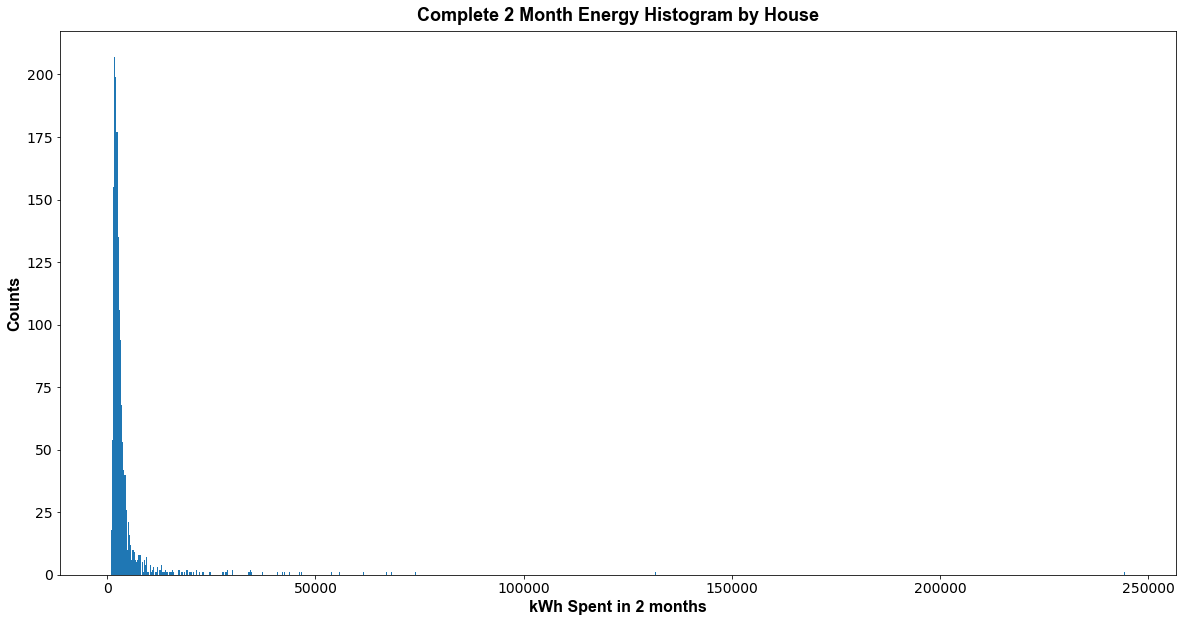

In [13]:
house_totals = ev_train_raw.drop(['House ID'], axis=1).sum(axis=1)
plt.figure(figsize=(20,10))
plt.hist(house_totals, bins='auto') 
plt.xlabel('kWh Spent in 2 months', **axis_font)
plt.ylabel('Counts', **axis_font)
plt.title("Complete 2 Month Energy Histogram by House", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

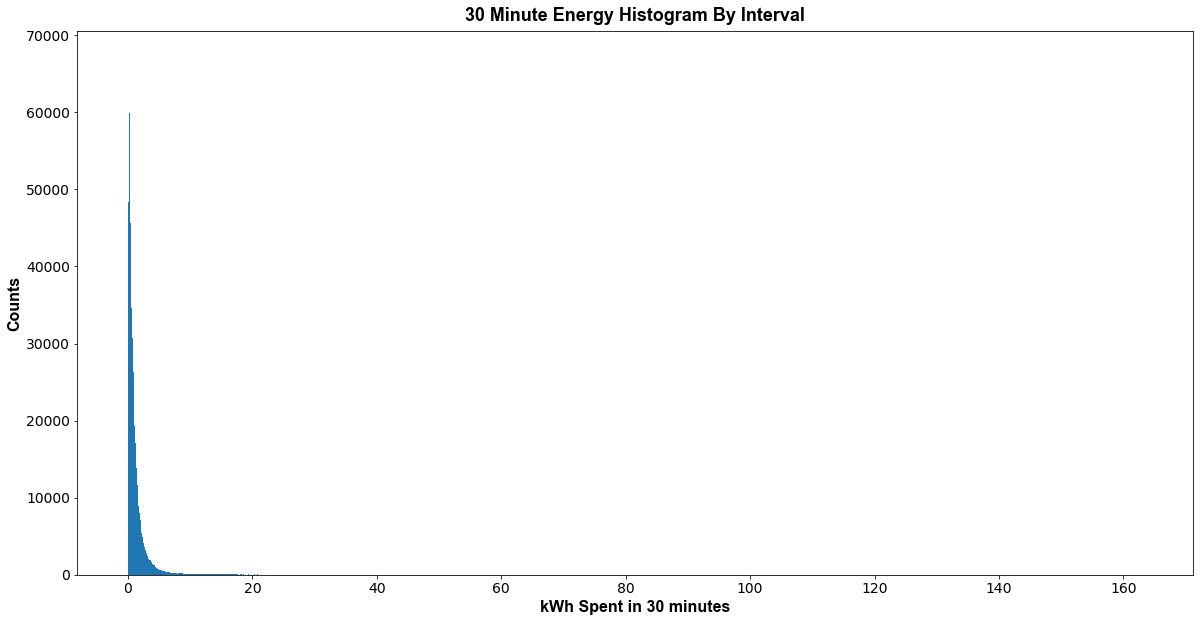

In [ ]:
interval_values = ev_train_raw.drop(['House ID'], axis=1).values.flatten()
interval_values = interval_values[~np.isnan(interval_values)]
plt.figure(figsize=(20,10))
plt.hist(interval_values, bins='auto') 
plt.xlabel('kWh Spent in 30 minutes', **axis_font)
plt.ylabel('Counts', **axis_font)
plt.title("30 Minute Energy Histogram By Interval", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

# Data Preprocessing

## Pivot and Combine

In [ ]:
ev_train_kwh_pivot = ev.pivot_raw_df(ev_train_raw, 'kWh')
display(ev_train_kwh_pivot.head())

In [ ]:
ev_train_labels_pivot = ev.pivot_raw_df(ev_train_labels_raw, 'Label')
display(ev_train_labels_pivot.head())

In [ ]:
ev_train_piv_w_lab = pd.concat([ev_train_kwh_pivot, ev_train_labels_pivot['Label']], axis=1)
display(ev_train_piv_w_lab.head())

## Add Temporal Dimensions

In [ ]:
ev_train_piv_lab_tmp = ev.add_temp_dim(ev_train_piv_w_lab)
display(ev_train_piv_lab_tmp.head())

## Fill in Missing Values

In [ ]:
ev_train_piv_lab_tmp_filled = ev.fill_with_mean(ev_train_piv_lab_tmp)
display(ev_train_piv_lab_tmp_filled.head())

# House Classification

## Training and Validation Split

In [ ]:
X_house, y_house = ev.house_agg_and_split(ev_train_piv_lab_tmp_filled)

In [ ]:
X_house.columns.values

In [ ]:
display(X_house.head())
display(y_house.head())

In [ ]:
# inspect for patterns at the house level
house_id_label = pd.concat([X_house['House ID'], y_house], axis=1)
display(house_id_label.head())

In [ ]:
house_id_label.groupby(['House Label']).agg(['mean','count'])

In [ ]:
house_id_label.corr()

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x=house_id_label['House ID'], y=house_id_label['House Label']) 
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Distribution of Positive and Negative Labels", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.show()

In [ ]:
X_train_house, X_valid_house, y_train_house, y_valid_house = train_test_split(X_house,
                                                                            y_house,
                                                                            test_size=0.25,
                                                                            random_state=42)

## Augment Data

## Perform K-Means Clustering

In [ ]:
Image(url= "http://aprs.org/Energy/Charging/L1-EV-timed-charging.GIF")

In [ ]:
X_train_house, centers_df, k_col_name = ev.cluster_retrieve_best_k(X_train_house, y_train_house)

Ratio defined as the maximum percent / minimum percent, where percent is the percent of positively identified EV houses in each of the k clusters. This helps discriminate ev houses depending on what cluster it belongs to.

In [ ]:
display(X_train_house.head())

## Train Model

### Modeling Attempts

In [ ]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# GBDT
if os.path.isfile('pickle_files/h_clf1_list.pkl'):
    with open('pickle_files/h_clf1_list.pkl', 'rb') as input:
        h_clf1_list = pickle.load(input)
        h_clf1 = h_clf1_list[0]
        h_clf1_time = h_clf1_list[1]
        print("Training Time (sec) : {}".format(h_clf1_time))
    
else:
    h_clf1 = GradientBoostingClassifier(random_state = 42)
    
    h_clf1_start = time.time()
    h_clf1.fit(X_train_house, y_train_house)
    h_clf1_end = time.time()
    h_clf1_time = h_clf1_end - h_clf1_start
    print("Training Time (sec) : {}".format(h_clf1_time))
    
    h_clf1_list = [h_clf1, h_clf1_time]
    save_object(h_clf1_list, 'pickle_files/h_clf1_list.pkl') 

    
y_train_house_pred1 = h_clf1.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred1)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred1)

In [ ]:
# Logistic Regression
if os.path.isfile('pickle_files/h_clf2_list.pkl'):
    with open('pickle_files/h_clf2_list.pkl', 'rb') as input:
        h_clf2_list = pickle.load(input)
        h_clf2 = h_clf2_list[0]
        h_clf2_time = h_clf2_list[1]
        print("Training Time (sec) : {}".format(h_clf2_time))
    
else:
    h_clf2 = LogisticRegression(random_state = 42)
    
    h_clf2_start = time.time()
    h_clf2.fit(X_train_house, y_train_house)
    h_clf2_end = time.time()
    h_clf2_time = h_clf2_end - h_clf2_start
    print("Training Time (sec) : {}".format(h_clf2_time))
    
    h_clf2_list = [h_clf2, h_clf2_time]
    save_object(h_clf2_list, 'pickle_files/h_clf2_list.pkl') 

    
y_train_house_pred2 = h_clf2.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred2)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred2)

In [ ]:
# Stochastic Gradient Descent
if os.path.isfile('pickle_files/h_clf3_list.pkl'):
    with open('pickle_files/h_clf3_list.pkl', 'rb') as input:
        h_clf3_list = pickle.load(input)
        h_clf3 = h_clf3_list[0]
        h_clf3_time = h_clf3_list[1]
        print("Training Time (sec) : {}".format(h_clf3_time))
    
else:
    h_clf3 = SGDClassifier(random_state = 42)
    
    h_clf3_start = time.time()
    h_clf3.fit(X_train_house, y_train_house)
    h_clf3_end = time.time()
    h_clf3_time = h_clf3_end - h_clf3_start
    print("Training Time (sec) : {}".format(h_clf3_time))
    
    h_clf3_list = [h_clf3, h_clf3_time]
    save_object(h_clf3_list, 'pickle_files/h_clf3_list.pkl') 

    
y_train_house_pred3 = h_clf3.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred3)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred3)

In [ ]:
# Support Vector Classification
if os.path.isfile('pickle_files/h_clf4_list.pkl'):
    with open('pickle_files/h_clf4_list.pkl', 'rb') as input:
        h_clf4_list = pickle.load(input)
        h_clf4 = h_clf4_list[0]
        h_clf4_time = h_clf4_list[1]
        print("Training Time (sec) : {}".format(h_clf4_time))
    
else:
    h_clf4 = SVC(random_state = 42)
    
    h_clf4_start = time.time()
    h_clf4.fit(X_train_house, y_train_house)
    h_clf4_end = time.time()
    h_clf4_time = h_clf4_end - h_clf4_start
    print("Training Time (sec) : {}".format(h_clf4_time))
    
    h_clf4_list = [h_clf4, h_clf4_time]
    save_object(h_clf4_list, 'pickle_files/h_clf4_list.pkl') 

    
y_train_house_pred4 = h_clf4.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred4)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred4)

In [ ]:
# Naive Bayes
if os.path.isfile('pickle_files/h_clf5_list.pkl'):
    with open('pickle_files/h_clf5_list.pkl', 'rb') as input:
        h_clf5_list = pickle.load(input)
        h_clf5 = h_clf5_list[0]
        h_clf5_time = h_clf5_list[1]
        print("Training Time (sec) : {}".format(h_clf5_time))
    
else:
    h_clf5 = GaussianNB()
    
    h_clf5_start = time.time()
    h_clf5.fit(X_train_house, y_train_house)
    h_clf5_end = time.time()
    h_clf5_time = h_clf5_end - h_clf5_start
    print("Training Time (sec) : {}".format(h_clf5_time))
    
    h_clf5_list = [h_clf5, h_clf5_time]
    save_object(h_clf5_list, 'pickle_files/h_clf5_list.pkl') 

    
y_train_house_pred5 = h_clf5.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred5)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred5)

In [ ]:
# Multi-layer Perceptron (Neural Networks)
if os.path.isfile('pickle_files/h_clf6_list.pkl'):
    with open('pickle_files/h_clf6_list.pkl', 'rb') as input:
        h_clf6_list = pickle.load(input)
        h_clf6 = h_clf6_list[0]
        h_clf6_time = h_clf6_list[1]
        print("Training Time (sec) : {}".format(h_clf6_time))
    
else:
    h_clf6 = MLPClassifier(random_state = 42)
    
    h_clf6_start = time.time()
    h_clf6.fit(X_train_house, y_train_house)
    h_clf6_end = time.time()
    h_clf6_time = h_clf6_end - h_clf6_start
    print("Training Time (sec) : {}".format(h_clf6_time))
    
    h_clf6_list = [h_clf6, h_clf6_time]
    save_object(h_clf6_list, 'pickle_files/h_clf6_list.pkl') 

    
y_train_house_pred6 = h_clf6.predict(X_train_house)

print("F1-Score: {}".format(f1_score(y_train_house, y_train_house_pred6)))

print("Confusion Matrix: ")
confusion_matrix(y_train_house, y_train_house_pred6)

### F1 Benchmark

In [ ]:
ev.show_baseline_f1_scores(y_train_house)

## Validate Model

In [ ]:
KNN_cols = ['p_{}'.format(n) for n in np.arange(1,49)]

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_house[KNN_cols], X_train_house[k_col_name]) 
X_valid_house[k_col_name] = neigh.predict(X_valid_house[KNN_cols])

The validation data did not go through k-means clustering. Instead, the cluster is predicted on the validation dataset using k-nearest neighbors (KNN). Where the KNN model was trained exclusively on the training dataset.

### Modeling Attempts

In [ ]:
# GBDT
y_valid_house_pred1 = h_clf1.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred1)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred1)

In [ ]:
# Logistic Regression
y_valid_house_pred2 = h_clf2.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred2)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred2)

In [ ]:
# Stochastic Gradient Descent
y_valid_house_pred3 = h_clf3.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred3)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred3)

In [ ]:
# Support Vector Classification
y_valid_house_pred4 = h_clf4.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred4)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred4)

In [ ]:
# Naive Bayes
y_valid_house_pred5 = h_clf5.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred5)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred5)

In [ ]:
# Multi-layer Perceptron (Neural Networks)
y_valid_house_pred6 = h_clf6.predict(X_valid_house)
print("F1-Score: {}".format(f1_score(y_valid_house, y_valid_house_pred6)))
print("Confusion Matrix: ")
confusion_matrix(y_valid_house, y_valid_house_pred6)

### F1 Benchmark

In [ ]:
ev.show_baseline_f1_scores(y_valid_house)

# Time Classification

## Training and Validation Split

In [ ]:
X_train_time, y_train_time = ev.transform_house_subset_to_time(
    X_train_house,
    y_train_house,
    ev_train_piv_lab_tmp_filled
)

In [ ]:
display(X_train_time.head())
display(y_train_time.head())

In [ ]:
X_valid_time, y_valid_time = ev.transform_house_subset_to_time(
    X_valid_house,
    y_valid_house_pred1, # predicted values from best house classifier, not true values!!!
    ev_train_piv_lab_tmp_filled
)

In [ ]:
display(X_valid_time.head())
display(y_valid_time.head())

## Augment Data

### Difference between Clusters and Intervals

In [ ]:
X_train_time_augmented = ev.augment_time_data(
    X_train_time, 
    X_train_house, 
    centers_df)
display(X_train_time_augmented.head())

In [ ]:
X_train_time_augmented.columns.values

In [ ]:
X_valid_time_augmented = ev.augment_time_data(
    X_valid_time, 
    X_valid_house, 
    centers_df) # centers do not reflect validation data
display(X_valid_time_augmented.head())

## Train Model

### Modeling Attempts

In [ ]:
# GBDT
if os.path.isfile('pickle_files/t_clf1_list.pkl'):
    with open('pickle_files/t_clf1_list.pkl', 'rb') as input:
        t_clf1_list = pickle.load(input)
        t_clf1 = t_clf1_list[0]
        t_clf1_time = t_clf1_list[1]
        print("Training Time (sec) : {}".format(t_clf1_time))
    
else:
    t_clf1 = GradientBoostingClassifier(random_state = 42)
    
    t_clf1_start = time.time()
    t_clf1.fit(X_train_time_augmented, y_train_time)
    t_clf1_end = time.time()
    t_clf1_time = t_clf1_end - t_clf1_start
    print("Training Time (sec) : {}".format(t_clf1_time))
    
    t_clf1_list = [t_clf1, t_clf1_time]
    save_object(t_clf1_list, 'pickle_files/t_clf1_list.pkl') 

    
y_train_time_pred1 = t_clf1.predict(X_train_time_augmented)

all_y_train_time_pred1, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred1,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred1)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred1)

In [ ]:
# Logistic Regression
if os.path.isfile('pickle_files/t_clf2_list.pkl'):
    with open('pickle_files/t_clf2_list.pkl', 'rb') as input:
        t_clf2_list = pickle.load(input)
        t_clf2 = t_clf2_list[0]
        t_clf2_time = t_clf2_list[1]
        print("Training Time (sec) : {}".format(t_clf2_time))
    
else:
    t_clf2 = LogisticRegression(random_state = 42)
    
    t_clf2_start = time.time()
    t_clf2.fit(X_train_time_augmented, y_train_time)
    t_clf2_end = time.time()
    t_clf2_time = t_clf2_end - t_clf2_start
    print("Training Time (sec) : {}".format(t_clf2_time))
    
    t_clf2_list = [t_clf2, t_clf2_time]
    save_object(t_clf2_list, 'pickle_files/t_clf2_list.pkl') 

    
y_train_time_pred2 = t_clf2.predict(X_train_time_augmented)

all_y_train_time_pred2, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred2,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred2)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred2)

In [ ]:
# Stochastic Gradient Descent
if os.path.isfile('pickle_files/t_clf3_list.pkl'):
    with open('pickle_files/t_clf3_list.pkl', 'rb') as input:
        t_clf3_list = pickle.load(input)
        t_clf3 = t_clf3_list[0]
        t_clf3_time = t_clf3_list[1]
        print("Training Time (sec) : {}".format(t_clf3_time))
    
else:
    t_clf3 = SGDClassifier(random_state = 42)
    
    t_clf3_start = time.time()
    t_clf3.fit(X_train_time_augmented, y_train_time)
    t_clf3_end = time.time()
    t_clf3_time = t_clf3_end - t_clf3_start
    print("Training Time (sec) : {}".format(t_clf3_time))
    
    t_clf3_list = [t_clf3, t_clf3_time]
    save_object(t_clf3_list, 'pickle_files/t_clf3_list.pkl') 

    
y_train_time_pred3 = t_clf3.predict(X_train_time_augmented)

all_y_train_time_pred3, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred3,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred3)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred3)

In [ ]:
# Naive Bayes
if os.path.isfile('pickle_files/t_clf5_list.pkl'):
    with open('pickle_files/t_clf5_list.pkl', 'rb') as input:
        t_clf5_list = pickle.load(input)
        t_clf5 = t_clf5_list[0]
        t_clf5_time = t_clf5_list[1]
        print("Training Time (sec) : {}".format(t_clf5_time))
    
else:
    t_clf5 = GaussianNB()
    
    t_clf5_start = time.time()
    t_clf5.fit(X_train_time_augmented, y_train_time)
    t_clf5_end = time.time()
    t_clf5_time = t_clf5_end - t_clf5_start
    print("Training Time (sec) : {}".format(t_clf5_time))
    
    t_clf5_list = [t_clf5, t_clf5_time]
    save_object(t_clf5_list, 'pickle_files/t_clf5_list.pkl') 

    
y_train_time_pred5 = t_clf5.predict(X_train_time_augmented)

all_y_train_time_pred5, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred5,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred5)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred5)

In [ ]:
# Multi-layer Perceptron (Neural Networks)
if os.path.isfile('pickle_files/t_clf6_list.pkl'):
    with open('pickle_files/t_clf6_list.pkl', 'rb') as input:
        t_clf6_list = pickle.load(input)
        t_clf6 = t_clf6_list[0]
        t_clf6_time = t_clf6_list[1]
        print("Training Time (sec) : {}".format(t_clf6_time))
    
else:
    t_clf6 = MLPClassifier(random_state = 42)
    
    t_clf6_start = time.time()
    t_clf6.fit(X_train_time_augmented, y_train_time)
    t_clf6_end = time.time()
    t_clf6_time = t_clf6_end - t_clf6_start
    print("Training Time (sec) : {}".format(t_clf6_time))
    
    t_clf6_list = [t_clf6, t_clf6_time]
    save_object(t_clf6_list, 'pickle_files/t_clf6_list.pkl') 

    
y_train_time_pred6 = t_clf6.predict(X_train_time_augmented)

all_y_train_time_pred6, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred6,
    X_train_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_train_time_true, all_y_train_time_pred6)))

print("Confusion Matrix: ")
confusion_matrix(all_y_train_time_true, all_y_train_time_pred6)

### F1 Benchmark

In [ ]:
ev.show_baseline_f1_scores(all_y_train_time_true)

## Validate Model

### Modeling Attempts

In [ ]:
# GBDT

y_valid_time_pred1 = t_clf1.predict(X_valid_time_augmented)

all_y_valid_time_pred1, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred1,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred1)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred1)

In [ ]:
# Logistic Regression

y_valid_time_pred2 = t_clf2.predict(X_valid_time_augmented)

all_y_valid_time_pred2, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred2,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred2)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred2)

In [ ]:
# Stochastic Gradient Descent

y_valid_time_pred3 = t_clf3.predict(X_valid_time_augmented)

all_y_valid_time_pred3, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred3,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred3)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred3)

In [ ]:
# Naive Bayes

y_valid_time_pred5 = t_clf5.predict(X_valid_time_augmented)

all_y_valid_time_pred5, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred5,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred5)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred5)

In [ ]:
# Multi-layer Perceptron (Neural Networks)

y_valid_time_pred6 = t_clf6.predict(X_valid_time_augmented)

all_y_valid_time_pred6, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred6,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

print("F1-Score: {}".format(f1_score(all_y_valid_time_true, all_y_valid_time_pred6)))

print("Confusion Matrix: ")
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred6)

### F1 Benchmark

In [ ]:
ev.show_baseline_f1_scores(all_y_valid_time_true)

## Validation Results in Original Format

In [ ]:
# use best classifier: GDBT

ev_train_label_predictions = ev.format_ev_predictions(
    all_y_valid_time_pred1, 
    all_Xy_valid_time
)

display(ev_train_label_predictions.head())

# Model Refinement

## House Grid Search

In [ ]:
X_train_house.shape

In [ ]:
# 0.75303643724696356 prior f1 score
print(h_clf1)

h_clf = GradientBoostingClassifier(random_state = 42)

scorer = make_scorer(f1_score)
h_cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
h_parameters = {'loss': ['deviance','exponential'],
              'learning_rate': [0.09, 0.1, 0.11],
              'n_estimators': [90, 100, 110],
              'max_depth': [2, 3, 4],
              'min_samples_leaf': [1, 2, 3],
             }      

h_grid_obj = GridSearchCV(estimator=h_clf, param_grid=h_parameters, scoring=scorer, cv=h_cv)

if os.path.isfile('pickle_files/h_grid_fit.pkl'):
    h_grid_fit = joblib.load('pickle_files/h_grid_fit.pkl')
else:
    h_grid_fit = h_grid_obj.fit(X_train_house, y_train_house)
    joblib.dump(h_grid_fit, 'pickle_files/h_grid_fit.pkl') 

best_h_clf = h_grid_fit.best_estimator_
print(best_h_clf)

y_valid_house_pred_best = best_h_clf.predict(X_valid_house)
f1_score(y_valid_house, y_valid_house_pred_best)

In [ ]:
h_importance_df = pd.DataFrame(best_h_clf.feature_importances_,
                              index=X_train_house.columns,
                              columns=['Importance'])

In [ ]:
h_importance_df.sort_values('Importance', ascending=False).head(30).plot.bar(figsize=(20,10)) 
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Sorted Feature Importance for House Classification", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=13)
plt.show()

## Time Grid Search

In [ ]:
print(X_train_time_augmented.shape)

In [ ]:
# 0.56518692056626818 prior f1 score
print(t_clf1)

t_clf = GradientBoostingClassifier(random_state = 42)

t_cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
t_parameters = {'learning_rate': [0.09,0.10,0.11],
              'max_depth': [2,3,4],
             }      

t_grid_obj = GridSearchCV(estimator=t_clf, param_grid=t_parameters, scoring=scorer, cv=t_cv)

if os.path.isfile('pickle_files/t_grid_fit.pkl'):
    t_grid_fit = joblib.load('pickle_files/t_grid_fit.pkl')
else:
    t_grid_fit = t_grid_obj.fit(X_train_time_augmented, y_train_time)
    joblib.dump(t_grid_fit, 'pickle_files/t_grid_fit.pkl') 

best_t_clf = t_grid_fit.best_estimator_
print(best_t_clf)

X_valid_time_best, y_valid_time_best = ev.transform_house_subset_to_time(
    X_valid_house,
    y_valid_house_pred_best, # use predicted values, not true values
    ev_train_piv_lab_tmp_filled
)

X_valid_time_best_augmented = ev.augment_time_data(
    X_valid_time_best, 
    X_valid_house, 
    centers_df)

y_valid_time_pred_best = best_t_clf.predict(X_valid_time_best_augmented)

all_y_valid_time_pred_best, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_best_augmented,
    y_valid_time_pred_best,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)

f1_score(all_y_valid_time_true, all_y_valid_time_pred_best)

In [ ]:
t_importance_df = pd.DataFrame(best_t_clf.feature_importances_,
                              index=X_train_time_augmented.columns,
                              columns=['Importance'])

In [ ]:
t_importance_df.sort_values('Importance', ascending=False).plot.bar(figsize=(20,10))
plt.xlabel('House ID', **axis_font)
plt.ylabel('Label', **axis_font)
plt.title("Sorted Feature Importance for Time Classification", **title_font)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=13)
plt.show()

# Predict Test Data

## Import

In [ ]:
ev_test_raw = pd.read_csv('source_files/EV_test.csv')

In [ ]:
print(ev_test_raw.shape)
display(ev_test_raw.head())

## Data Preprocessing

In [ ]:
print(ev_test_raw.isnull().values.any())
display(ev_test_raw[ev_test_raw.isnull().any(axis=1)])

In [ ]:
ev_test_kwh_pivot = ev.pivot_raw_df(ev_test_raw, 'kWh')
display(ev_test_kwh_pivot.head())

In [ ]:
ev_test_kwh_tmp = ev.add_temp_dim(ev_test_kwh_pivot)
display(ev_test_kwh_tmp.head())

In [ ]:
ev_test_kwh_tmp_filled = ev.fill_with_mean(ev_test_kwh_tmp)
display(ev_test_kwh_tmp_filled.head())

## House Clasification

In [ ]:
X_test_house = ev.house_agg_and_split(ev_test_kwh_tmp_filled, has_label=False)
display(X_test_house.head())

In [ ]:
X_test_house[k_col_name] = neigh.predict(X_test_house[KNN_cols]) # use trained KNN classifier
display(X_test_house.head())

In [ ]:
y_test_house_pred = best_h_clf.predict(X_test_house) # use best trained house classifier via Grid Search

## Time Classification

In [ ]:
X_test_time = ev.transform_house_subset_to_time(
    X_test_house,
    y_test_house_pred,
    ev_test_kwh_tmp_filled,
    has_label=False
)
display(X_test_time.head())

In [ ]:
X_test_time_augmented = ev.augment_time_data(
    X_test_time, 
    X_test_house, 
    centers_df) 
display(X_test_time_augmented.head())

In [ ]:
X_test_time_augmented.columns.values

In [ ]:
y_test_time_pred = best_t_clf.predict(X_test_time_augmented) # use best trained time classifier via Grid Search

## Format Final Result

In [ ]:
all_y_test_time_pred, all_y_test_time_true, all_Xy_test_time = ev.get_all_relevant_preds_and_trues(
    X_test_time_augmented,
    y_test_time_pred,
    X_test_house,
    ev_test_kwh_tmp_filled)
display(all_Xy_test_time.head()) 

In [ ]:
ev_test_label_predictions = ev.format_ev_predictions(
    all_y_test_time_pred, 
    all_Xy_test_time
)
display(ev_test_label_predictions.head())

In [ ]:
ev_test_label_predictions.to_csv('submissions/EV_test_labels.csv', index=False)